# <center> Guia 3 </center>
Alumnes: Borrel Trinidad, Brusco Agustín

Docentes: Rodriguez Imazio Paola, Amette Estrada Julian

## Imports Generales
Ejecutar la siguiente celda para poder correr el código del Notebook.

In [1]:
import sys
import os
# Colab Set-Up
if ("google.colab" in sys.modules) and (os.getcwd() == '/content'):
    print(
        "Ejecutando en Google Colab\n"
        "Para correr el notebook se necesita clonar un repositorio con funciones "
        "auxiliares e instalar librerías."
    )
    if input(
        "¿Desea clonar el repositorio e instalar los paquetes necesarios?"
        "[y/n]:"
    ).lower() == "y":
        os.system("git clone https://github.com/agustinbrusco/Sistemas_Complejos.git")
        print(
            "Se clonó https://github.com/agustinbrusco/Sistemas_Complejos.git."
        )
        os.chdir("Sistemas_Complejos/guias/")
        %pip install findiff
        %pip install ipympl
    from google.colab import output
    output.enable_custom_widget_manager()

# Imports Generales
from typing import Callable
import numpy as np
from numpy.typing import ArrayLike
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

from utils import (plot_3d_evolution)

# Modelo de población
## <center> Ecuación logística </center>

Vamos a partir de un sistema gobernado por la ecuación:

$$\frac{\partial N}{\partial t}(x,t) = \alpha \left( 1 - \frac{1}{C(x,t)}N \right) + \nu \nabla^2 N.$$

Esta ecuación es una versión de la ecuación logística. Podemos interpretarlo como un modelo de población tanto en el espacio como en el tiempo donde $N(x,t)$ es la población que se encuentra en cierta posición en un determinado tiempo, $C(x,t)$ representa el valor de saturación de la población dado los recursos que se encuentran, $\alpha$ es la tasa de creciciento de la población cuando existen infinitos recursos y $\nu$ un parámetro que determina la migración de individuos hacia áreas menos pobladas.

Utilizaremos para este modelo recursos que oscilarán en el espacio y el tiempo, representando el cambio en las estaciones de las zonas más aptas para vivir. Entonces, tendrá la forma funcional:

$$ C(x,t) = c_0 (1 + 0.8 \cos(\omega_1 t) \sin (\omega_2 x)).$$

$\bf a)$ Escriba un método pseudoespectral (con Runge-Kutta de orden 2 midpoint para el tiempo) que integre el sistema presentado anteriormente usando $N = 1024$ puntos de grilla, $dt = 1 \times 10^{-3}$, $\nu = 5 \times 10^{-5}$, $\alpha = 3$, $c_0 = 15$, $t_f = 4 \pi$, $\omega_1 = 2$, $\omega_2 = 1$ y $x \in [0, 2\pi]$. Use como condición inicial una población constante de 10 en todos lados. Grafique como una imagen $N(x,t)$.

$\bf b)$ Aplique la técnica de descomposición ortogonal empírica para separar la solución en componentes temporales y espaciales. Grafique ordenadamente los autovalores e interprete su significado. Grafique para distinto número de modos (1, 2, 3, etc) y relacionelo con los autovalores. ¿Qué criterio puede utilizar para elegir el número de modos?

$\bf c)$ Plantee analíticamente una descomposición de Galerkin en funciones genéricas para esta ecuación. (se recomienda hacerlo con detenimiento)

$\bf e)$ Ahora realice el proceso inverso. Usando el item $\bf b$, escriba un código que tome los primeros $n$ modos que obtiene de POD y escriba un integrador que evolucione estos modos. Use las mismas condiciones que en el item $a$. Para la condición inicial proyecte la utilizada en los modos elegidos. Pruebe para tres $n$ distintos y que uno sea 3.¿Qué conclusiones obtiene?

$\bf f)$ Para $n=3$ varíe el parámetro $\alpha$ y use el integrador obtenido del punto anterior. En este caso no estaremos usando los modos de POD que sabemos que forman parte de la solución. Compare con la integración directa de este caso. ¿Por qué los modos POD de un problema con otros parámetros sigue funcionando en este caso?

$\bf g)$ Repita el punto anterior pero ahora con $\omega_1 = 1$.


$\bf h)$ Escriba un integrador temporal para de 3 modos Fourier para esta ecuación (se recomienda reciclar el anterior). Compare con los resultados de POD que obtuvo en el item $\bf e$.

(opcional: encuentre un régimen nuevo de parámetros para los cuales los 3 modos obtenidos de POD no permiten reflejar la dinámica)

[IMPORTANTE: RESOLVER LOS ITEMS EN CELDAS SEPARADAS, MARCANDO CLARAMENTE EL I]


### a)
Primero tenemos la Ecuación Logistica en Derivadas Parciales en el caso de una dimensión:
$$\frac{\partial N}{\partial t}(x,t) = \alpha \left( 1 - \frac{1}{C(x,t)}N \right) + \nu \frac{\partial^2 N}{\partial x^2}$$
Transformando en Fourier la coordenada espacial $x$ y notando $\hat{N}(k,t)$ a la transformada de Fourier de $N(x,t)$, tenemos:
$$\frac{\partial \hat{N}}{\partial t}(k,t) = \alpha \,\mathcal{F}\left[ 1 - \frac{1}{C(x, t)}\mathcal{F}^{-1}\left[\hat{N}\right]\right] - \nu k^2 \hat{N}$$

Definiendo ahora el lado derecho de la ecuación como $\phi(t, \hat{N})$, tenemos que el método de Runge-Kutta de orden 2 midpoint para el tiempo queda:
$$\hat{N}_{t + \mathrm{d} t} = \hat{N}_{t} + \mathrm{d} t \cdot \phi\left(t + \mathrm{d} t/2, \hat{N}_{t} + \frac{\mathrm{d} t}{2} \cdot \phi\left(t, \hat{N}_{t}\right)\right)$$

In [2]:
def evol(
    n: ArrayLike,
    k: ArrayLike,
    c_t: Callable[[float], ArrayLike],
    alpha: float,
    nu: float,
    dt: float,
    t: float,
) -> ArrayLike:
    """Evoluciona en el tiempo la PDE usando el método pseudoespectral y \
Runge-Kutta de segundo orden.
    """
    n_hat = np.fft.rfft(n)  # Transformamos al espacio de Fourier
    n_hat_inicial = n_hat  # Guardamos el estado inicial
    for ord in [2,1]:  # Bucle para el Runge-Kutta
        D = dt/ord
        recursos_hat = calcular_recursos(n_hat, c_t(t + dt*(0.5 - 1/ord)))
        n_hat = n_hat_inicial + D*(alpha*recursos_hat - nu*(k**2)*n_hat)  # Integramos en el tiempo
        n_hat[n.size//3:] = 0  # Dealiasing (eliminemos modos espúreos!)
    n_nuevo = np.fft.irfft(n_hat)  # Vuelva del espacio de Fourier
    return n_nuevo

def calcular_recursos(n_hat: ArrayLike, c: ArrayLike) -> ArrayLike:
    """Calcula: $1 - \frac{1}{C(x, t)}\mathcal{F}^{-1}\left[\hat{N}\right]$ \
usando el método pseudoespectral y devuelve el resultado en el espacio Fourier.
    """
    n = np.fft.irfft(n_hat)
    recursos_hat = np.fft.rfft(1 - n/c)
    return recursos_hat

En la siguiente celdas integramos las condiciones iniciales $N(x, 0) = 10$ para obtener una solución que se utilizará a lo largo de la guía.

In [3]:
nx = 1024
dt = 1e-3
tf = 4 * np.pi
L = 2 * np.pi

x_vals = np.linspace(0, L, nx, endpoint=True)  # Coordenada espacial en [0,2*pi]
t_vals = np.arange(0, tf + dt/2, dt)  # Tiempo
x_grid, t_grid = np.meshgrid(x_vals, t_vals, indexing="xy")  # Grilla para graficar
nt = t_vals.size
# Números de onda ordenados como en la FFT
k_vals = np.fft.rfftfreq(nx, d=(x_vals[1] - x_vals[0])) * 2 * np.pi

In [4]:
# Parámetros del modelo
nu = 5e-5
alpha = 3

def c_func(
    x: ArrayLike,
    t: ArrayLike,
    c0: float,
    w1: float,
    w2: float,
) -> ArrayLike:
    return c0 * (1 + 0.8 * np.cos(w1*t) * np.sin(w2*x))

N = np.empty([nx, nt])  # Array con la velocidad
N[:, 0] = np.full_like(x_vals, 10, dtype=float)  # CI: 10 individuos en todos los puntos

# Evolucionamos en el tiempo
for i, t_i in enumerate(t_vals[:-1]):
    N[:, i+1] = evol(
        N[:, i],
        k_vals,
        lambda t: c_func(x_vals, t, c0=15, w1=2, w2=1),
        alpha,
        nu,
        dt,
        t_i,
    )

Graficamos la solución obtenida en la celda anterior:

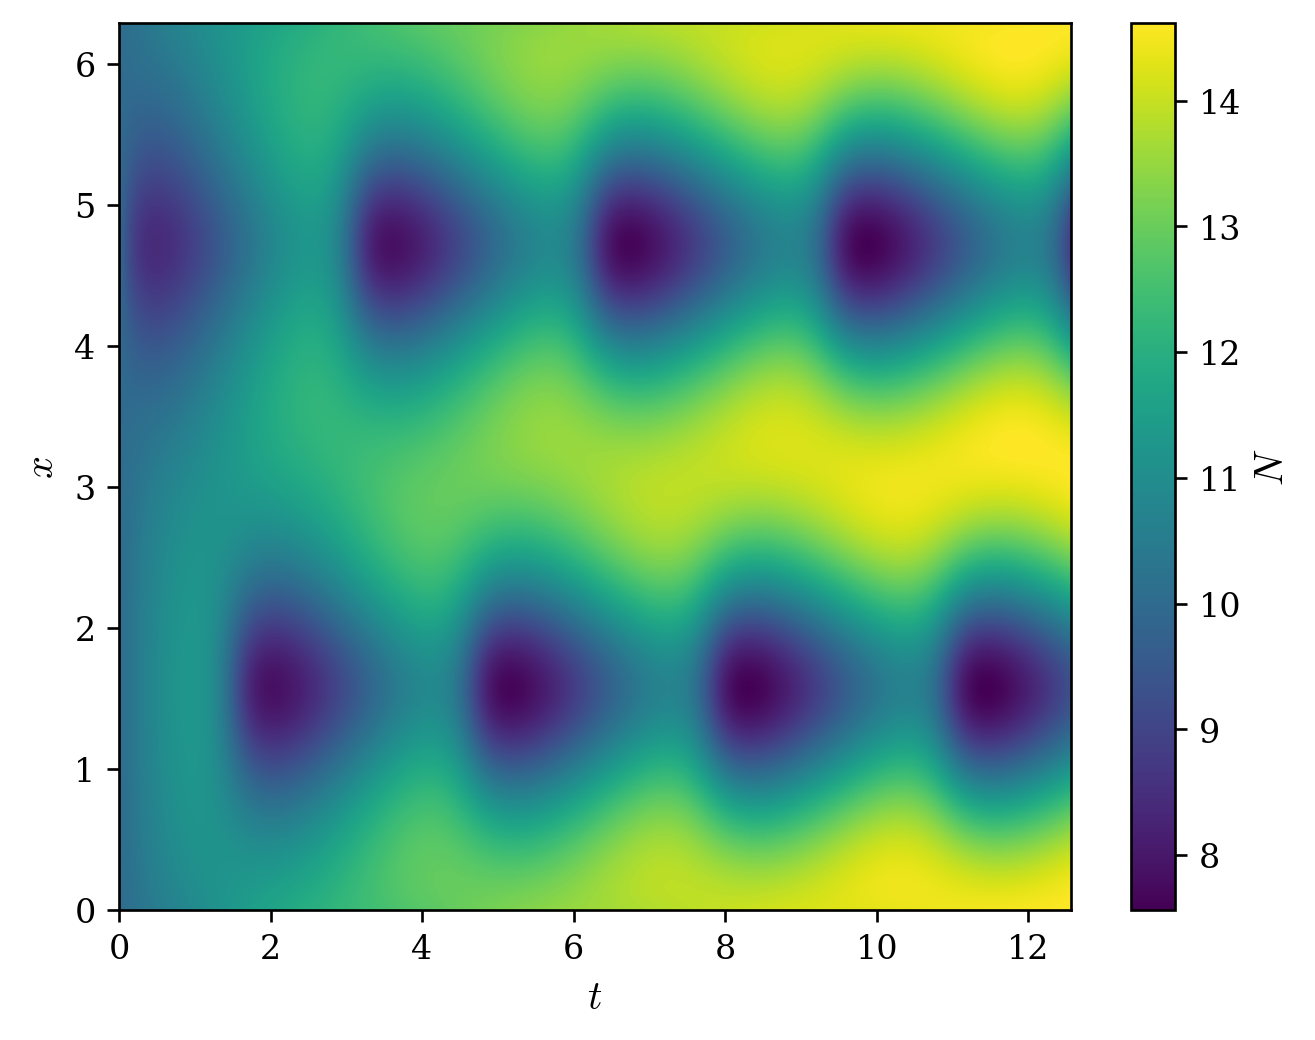

In [18]:
%matplotlib inline
plt.figure()
plt.pcolormesh(t_grid, x_grid, N.T, shading="auto", cmap="viridis")
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.colorbar(label="$N$")
plt.show()

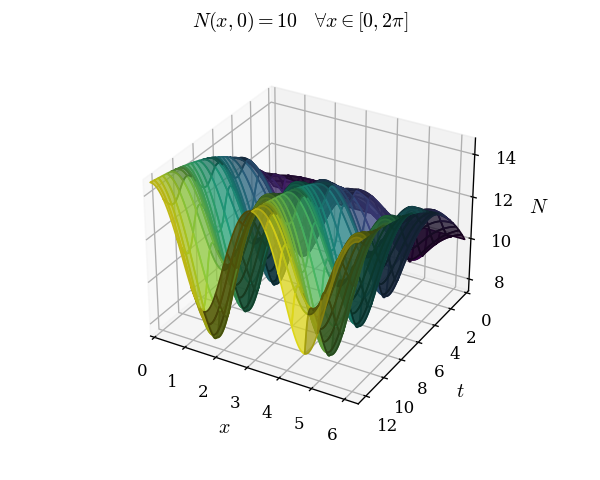

In [19]:
%matplotlib widget
fig, ax, v_cmap = plot_3d_evolution(x_vals, t_vals, N, cmap_name="viridis", t_sample_size=16, x_sample_size=32)
fig.set_label("Evolución de la Ecuación Logística mediante Método Pseudoespectral")
fig.suptitle(r"$N(x, 0) = 10 \quad \forall x \in [0, 2\pi]$")
ax.set_zlabel("$N$")
plt.show()

In [20]:
plt.close("all")

### b)

Para calcular la POD de esta solución resolvemos el problema de autovalores y autovectores para:
$$\frac{1}{n_t}N N^T \vec{\phi}_i = \lambda \vec{\phi}_i \quad \mathrm{con} \quad i \in \mathbb{N}_{< n_x}$$
dónde $n_t$ y $n_x$ son la cantidad de puntos en la grilla temporal y espacial respectivamente y $N \in \mathbb{R}^{n_x \times n_t}$ es la matriz de datos de la solución. Luego, acomodando los autovalores y autovectores en orden de mayor a menor autovalor, podemos definir la matriz $\Phi$ de modos espaciales cuyas columnas son los autovectores (modos) $\vec{\phi}_i$ según:
$$\Phi = \begin{pmatrix}
| & | & & | \\
\vec{\phi}_1 & \vec{\phi}_2 & \cdots & \vec{\phi}_{n_x - 1} \\
| & | & & |
\end{pmatrix}\quad \in \mathbb{R}^{n_x \times n_x} $$

Finalmente, podemos encontrar la evolución de estos modos en el tiempo proyectando la solución sobre los modos espaciales para cada tiempo $t$:
$$\vec{a}_i = N^T \vec{\phi}_i$$
O bien matricialmente para todos los modos:
$$A = N^T \Phi$$
dónde $A$ es la matriz de pesos en función del tiempo cuyas columnas son los vectores $\vec{a}_i$ según:
$$A = \begin{pmatrix}
| & | & & | \\
\vec{a}_1 & \vec{a}_2 & \cdots & \vec{a}_{n_x - 1} \\
| & | & & |
\end{pmatrix}\quad \in \mathbb{R}^{n_t \times n_x} $$

In [5]:
autovals, phi = np.linalg.eigh((N / nt) @ (N.T), )
# np.sum(phi**2, axis=1)  # Los vectores phi están normalizados
sorted_args = np.argsort(np.abs(autovals))[::-1]
autovals = autovals[sorted_args]
phi = phi[:, sorted_args]
a = N.T @ phi

A continuación graficamos los autovalores asociados a los modos ordenados de mayor a menor valor absoluto:

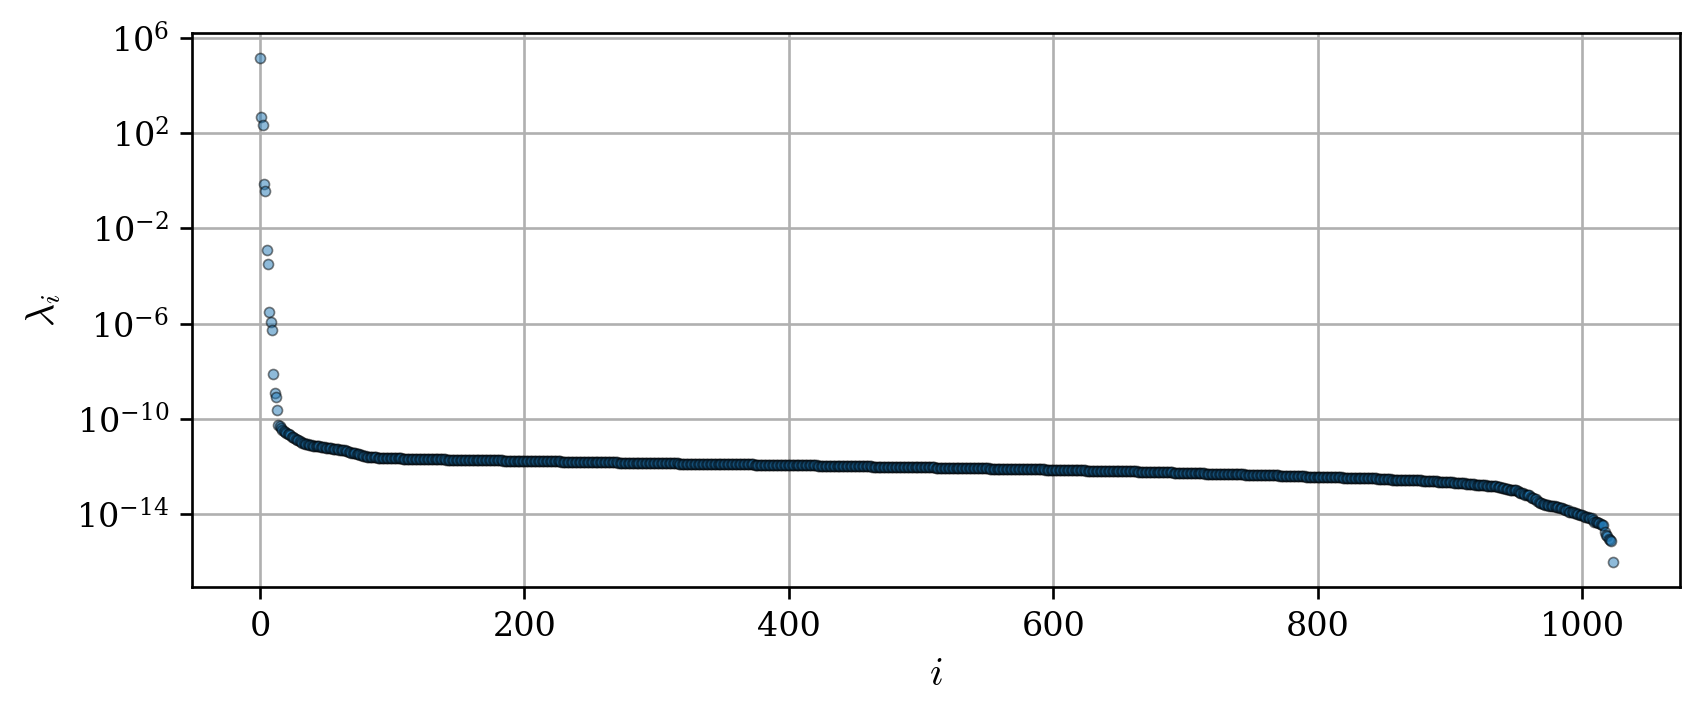

In [22]:
%matplotlib inline
plt.figure(figsize=(8, 3))
plt.plot(np.arange(len(autovals)), np.abs(autovals), '.', mec="k", mew=0.5, alpha=0.5)
plt.grid()
plt.yscale("log")
plt.ylabel("$\lambda_i$")
plt.xlabel("$i$")
# plt.xlim(-1, 30)
plt.show()

Observando los valores de $\lambda_i$ ordenados resulta notable que el primer autovalor es ordenes de magnitud más grande que los demás. Esto es: en la evolución del sistema, el modo de mayor autovalor tiene $\sim 10^{15}$ veces más peso que los modos 15 en adelante (cuyos autovalores son del orden de $10^{-10}$)

A continuación podemos ver cómo los primeros 3 modos espaciales acumulan un peso relativo mayor al 99.999\% de la solución total. Esto es, podemos aproximar la solución con estos 3 modos y obtener una solución que es prácticamente igual a la original.

$$\frac{\sum_{i = 0}^{n} |\lambda_i|}{\sum_{i=0}^{n_x} |\lambda_i|}$$

In [40]:
print(*[f"Hasta {n=}: {val:.8%}" for n, val in enumerate((np.abs(autovals).cumsum()/np.abs(autovals).sum()))][:5],
      sep="\n",
      end="\n...",
)

Hasta n=0: 99.49424279%
Hasta n=1: 99.84700893%
Hasta n=2: 99.99921717%
Hasta n=3: 99.99974474%
Hasta n=4: 99.99999892%
...

En la siguiente celda mostramos la solución reconstruida a partir de los 3 modos más relevantes:

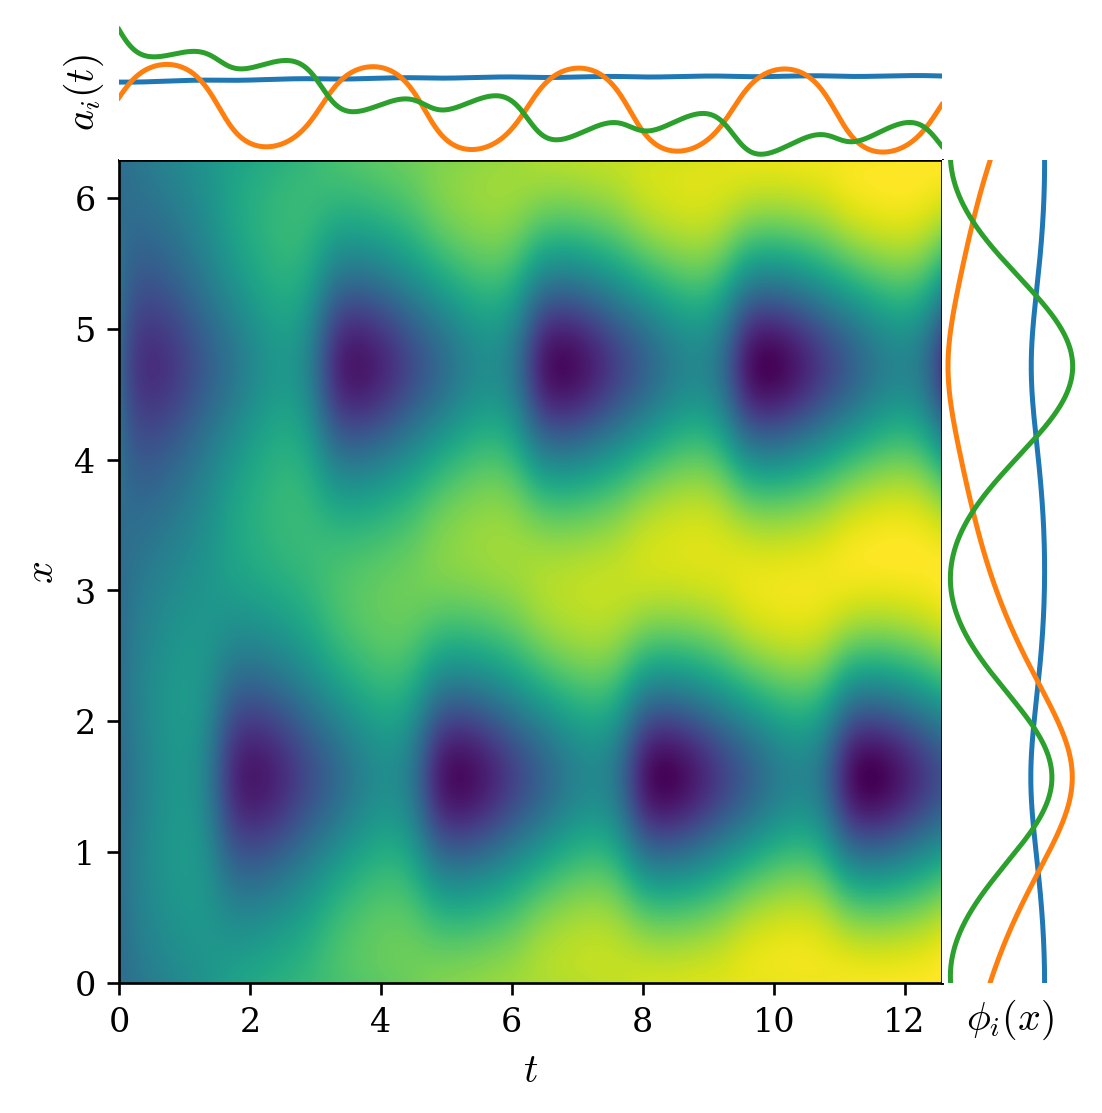

In [11]:
%matplotlib inline
fig = plt.figure(figsize=(5, 5))

# Also adjust the subplot parameters for a square plot.
edge_axis_ratio = 6
gs = fig.add_gridspec(
    2, 2,
    width_ratios=(edge_axis_ratio, 1), height_ratios=(1, edge_axis_ratio),
    left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.0, hspace=0.0
)
# Create the Axes.
ax_center = fig.add_subplot(gs[1, 0])
ax_x = fig.add_subplot(gs[0, 0], sharex=ax_center)
ax_y = fig.add_subplot(gs[1, 1], sharey=ax_center)

    

# Defino los modosa graficar:
i_min = 0
i_max = 2
n_truncado = phi[:, i_min:i_max+1] @ a[:, i_min:i_max+1].T

# Plot central con la imagen de la solución truncada
ax_center.pcolormesh(t_grid, x_grid, n_truncado.T, shading="auto", cmap="viridis")
ax_center.set_xlabel("$t$")
ax_center.set_ylabel("$x$")

# Plots de los bordes con φ_i(x) y a_i(t)
for i in range(i_min, i_max+1):
    # ax_x.scatter(t_vals, a[:, i], cmap="viridis", c=a[:, i], s=1)
    ax_x.plot(t_vals, a[:, i]/autovals[i]**0.5, "-")
    # ax_y.scatter(phi[:, i], x_vals, cmap="viridis", c=phi[:, i], s=1)
    ax_y.plot(phi[:, i], x_vals, "-")

    
if i_max == i_min:
    ax_x.set_ylabel(fr"$a_{i}(t)$")
    ax_y.set_xlabel(fr"$\phi_{i}(x)$")
else:
    ax_x.set_ylabel(r"$a_{i}(t)$")
    ax_y.set_xlabel(r"$\phi_{i}(x)$")
for ax in [ax_x, ax_y]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # Hide ticks and labels
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False,
    )
plt.show()

Además, para tener una noción de cómo se comportan los modos espaciales, graficamos la evolución temporal de los 6 primeros modos espaciales (ordenados de izquierda a derecha y arriba a abajo). En los costados de cada gráfico mostramos los $\vec{a}_i$ (arriba) y $\vec{\phi}_i$ (derecha) correspondientes:

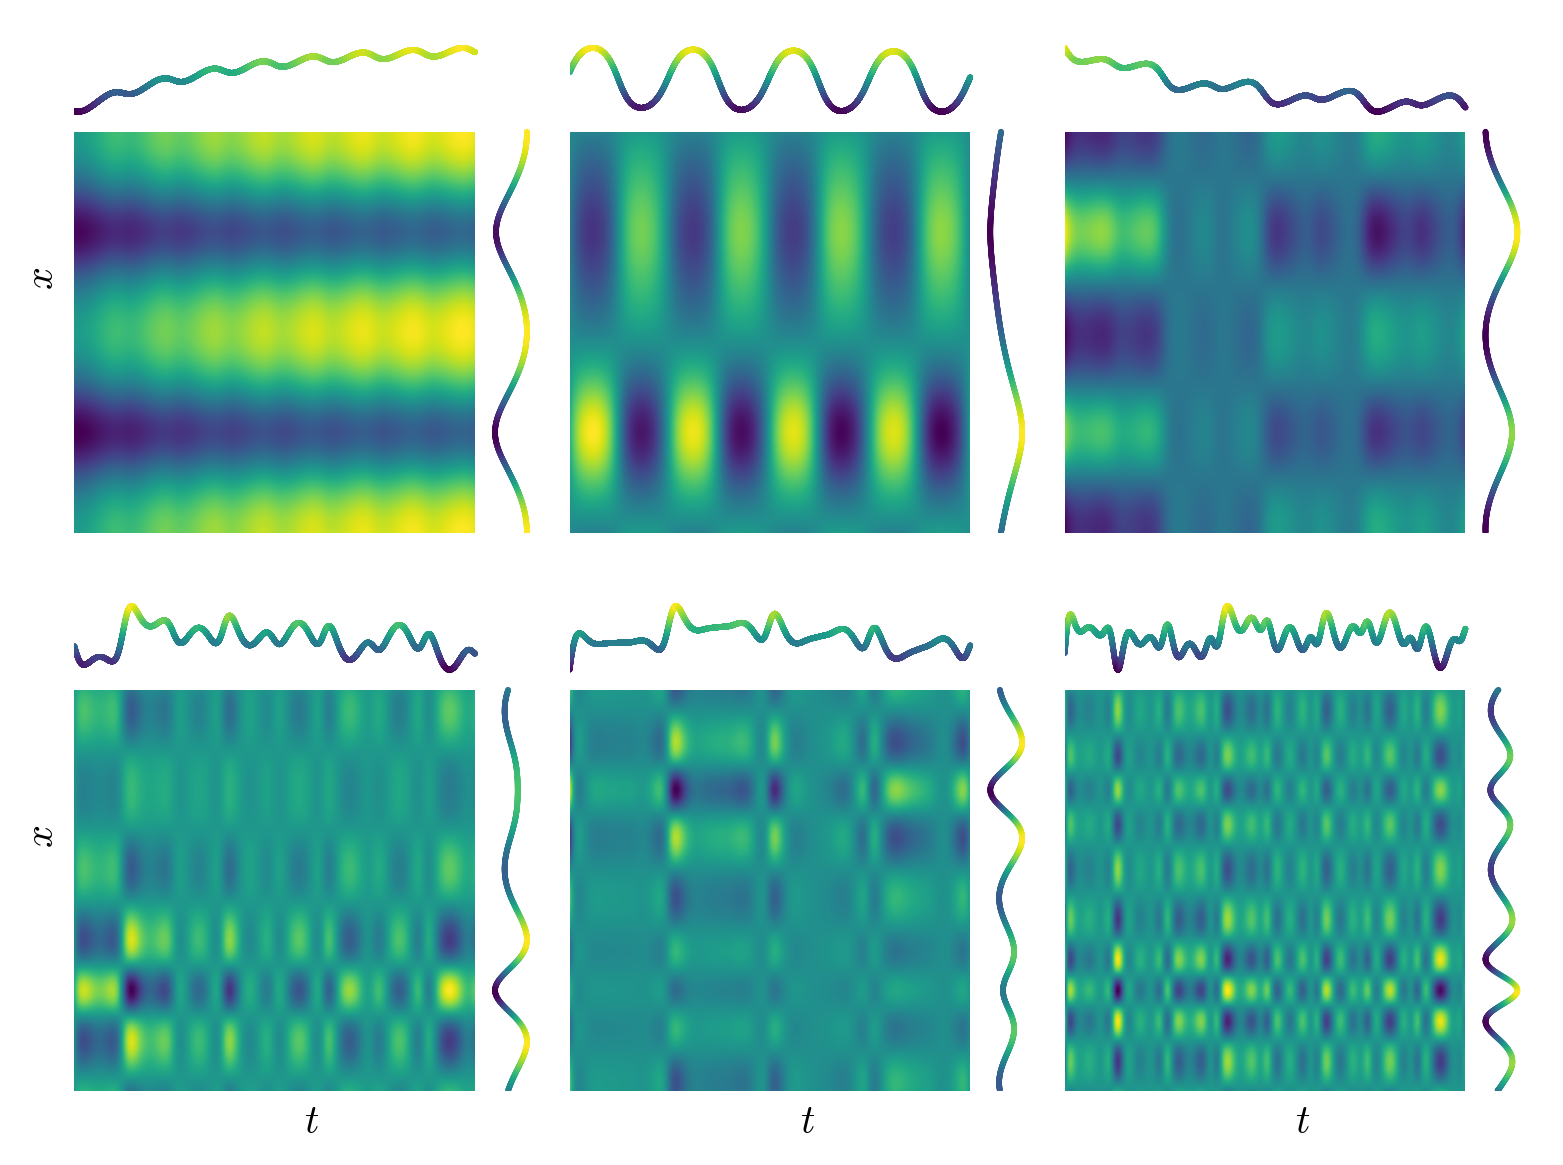

In [13]:
%matplotlib inline
fig, axs = plt.subplots(
    2, 3,
    sharex=True, sharey=True,
    constrained_layout=True, squeeze=False,
)
for i, ax in enumerate(axs.flatten()):
    modo = phi[:, i:i+1] @ a[:, i:i+1].T
    modo_cmap = plt.cm.ScalarMappable(
        norm=plt.Normalize(modo.flatten().min(), modo.flatten().max()),
        cmap="viridis",
    )
    ax.pcolormesh(
        t_grid, x_grid,
        modo_cmap.to_rgba(modo.T),
        shading="auto",
    )
    a_plot = a[:, i]
    a_plot -= a_plot.min()
    a_plot /= a_plot.max()
    a_cmap = plt.cm.ScalarMappable(
        norm=plt.Normalize(a[:, i].min(), a[:, i].max()),
        cmap="viridis",
    )
    ax.scatter(
        t_vals, a_plot + x_vals.max()*1.05,
        s=0.5, c=a_cmap.to_rgba(a[:, i]),
    )
    phi_plot = phi[:, i]
    phi_plot -= phi_plot.min()
    phi_plot /= phi_plot.max()
    phi_cmap = plt.cm.ScalarMappable(
        norm=plt.Normalize(phi[:, i].min(), phi[:, i].max()),
        cmap="viridis",
    )
    ax.scatter(
        phi_plot + t_vals.max()*1.05, x_vals,
        s=0.5, c=phi_cmap.to_rgba(phi[:, i])
    )
    for edge in ["top", "right", "bottom", "left"]:
        ax.spines[edge].set_visible(False)
    ax.set_aspect(t_vals.max() / x_vals.max())
for ax in axs[-1]:
    ax.set_xlabel("$t$")
for ax in axs[:, 0]:
    ax.set_ylabel("$x$")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### c)

Para desarrollar Galerkin la ecuación $\frac{\partial N}{\partial t}(x,t) = \alpha \left( 1 - \frac{1}{C(x,t)}N \right) + \nu \nabla^2 N$ procedemos a proponer una descomposición según:
$$N(x, t) = \sum_{i = 0}^\infty a_i(t)\, \phi_i(x)$$
Donde definimos que $\left\{\phi_i(x)\right\}_{i \in \mathbb{N}}$ es una base ortonormal de funciones en $x$ tal que:
$$\int\limits_{-\infty}^{\infty} \phi_j^*(x) \phi_i(x) \omega(x)\, \mathrm{d}x = \delta_{ij}$$

Luego, reemplazando la descomposición de $N$ en la ecuación original:
$$\begin{align*}
    \sum_{i = 0}^\infty \dot{a}_i(t)\, \phi_i(x) = & \alpha \left( 1 - \frac{1}{C(x,t)}\sum_{i=0}^\infty a_i(t)\, \phi_i(x) \right) \\
    & + \nu \sum_{i=0}^\infty a_i(t)\, \frac{\partial^2}{\partial x^2} \phi_i(x) \\
\end{align*}$$
Y multiplicando por $\phi_j^*(x) \omega(x)$ e integrando en todo el dominio espacial tenemos:
$$\begin{align*}
    \dot{a}_j(t) = & \,\alpha\left( \int\limits_{-\infty}^{\infty} \phi_j^*(x) \omega(x)\, \mathrm{d}x - \sum_{i=0}^\infty a_i(t)\, \int\limits_{-\infty}^{\infty} \frac{\phi_j^*(x) \phi_i(x) \omega(x)}{C(x,t)}\, \mathrm{d}x \right) \\
    & + \nu \sum_{i=0}^\infty a_i(t)\, \int\limits_{-\infty}^{\infty} \phi_j^*(x) \frac{\partial^2}{\partial x^2} \phi_i(x) \omega(x)\, \mathrm{d}x \\
\end{align*}$$

Definiendo entonces el vector $A_j = \int\limits_{-\infty}^{\infty} \phi_j^*(x) \omega(x)\, \mathrm{d}x$, la matriz $T_{ij}(t) = \int\limits_{-\infty}^{\infty} \phi_j^*(x) \frac{\phi_i(x)}{C(x,t)} \omega(x)\, \mathrm{d}x$ y la matriz $B_{ij} = \int\limits_{-\infty}^{\infty} \phi_j^*(x) \frac{\partial^2}{\partial x^2} \phi_i(x) \omega(x)\, \mathrm{d}x$, podemos escribir la ecuación de evolución de los coeficientes como:
$$\dot{a}_i(t) = \alpha\left( A_i - \sum_{i=0}^\infty T_{ij}(t)\, a_j(t) \right) + \nu \sum_{i=0}^\infty B_{ij}\, a_j(t)$$
$$\iff \dot{\vec{a}}(t) = \alpha\left( \vec{A} - \mathbb{T}(t)\, \vec{a}(t) \right) + \nu \mathbb{B}\, \vec{a}(t)$$
$$\iff \dot{\vec{a}}(t) = \alpha \vec{A} - \left(\alpha \mathbb{T}(t) - \nu \mathbb{B}\right)\, \vec{a}(t)$$

### e)

Para escribir un integrador a partir de la expresión obtenida necesitamos discretizar en $x$ para calcular $\vec{A}$ y las matrices $\mathbb{T}$ y $\mathbb{B}$.

Al discretizar en $x$ pasamos de tener infinitas funciones $\phi_i(x):\mathbb{R}\to\mathbb{R}$ a tener $n_x$ vectores $\vec{\phi}_i \in \mathbb{R}^{n_x}$. A su vez, la condición de ortonormalidad pasa a ser $\vec{\phi}_j^* \vec{\phi}_i = \delta_{ij}$. Así, las integrales pasan a ser sumas a lo largo de las coordenadas espaciales de manera que se tiene:
$$\begin{align*}
A_j&  = \vec{\phi}_j^* \cdot \vec{1}\quad & \Rightarrow \quad &\vec{A} = \Phi^* \vec{1} \\
T_{ij}&  = \vec{\phi}_j^* \cdot \overrightarrow{\frac{\phi_i}{C(\vec{x}, t)}}\quad & \Rightarrow \quad &\mathbb{T}(t) = \Phi^* \mathbb{C}(t) \\
B_{ij}&  = \vec{\phi}_j^* \cdot \mathbb{D}_2 \cdot \vec{\phi}_i\quad & \Rightarrow \quad &\mathbb{B} = \Phi^* \mathbb{D}_2 \Phi \\
\end{align*}$$
dónde $\Phi$ es la matriz cuyas columnas son $\vec{\phi}_i$, $\mathbb{C}(t)$ es la matriz cuyas columnas son $\overrightarrow{\frac{\phi_i}{C(\vec{x}, t)}}$ y $\mathbb{D}_2$ es la matriz de diferencias finitas de segundo orden con condiciones de contorno adecuadas.


In [5]:
# Calculo de nuevo los modos como en b)
autovals, phi = np.linalg.eigh((N / nt) @ (N.T), )
# np.sum(phi**2, axis=1)  # Los vectores phi están normalizados
sorted_args = np.argsort(np.abs(autovals))[::-1]
autovals = autovals[sorted_args]
phi = phi[:, sorted_args]
a = N.T @ phi


# Defino la matriz \mathbb{C}(t)
def c_matrix(phi_matrix: ArrayLike, x_vals: ArrayLike, t: ArrayLike, c0: float, w1: float, w2: float):
    c_vals = c_func(x_vals, t, c0, w1, w2)
    cols = [phi/c_vals for phi in phi_matrix.T]
    return np.column_stack(cols)

# Defino la matriz \mathbb{D}_2
dx = x_vals[1] - x_vals[0]
D_2 = (np.eye(nx, k=1) - 2 * np.eye(nx) + np.eye(nx, k=-1))
D_2[-1, 0], D_2[0, -1] = 1, 1  # contorno periódico
D_2 /= (dx**2)

Para $\mathbb{D}_2$ usamos condiciones de contorno períodicas (con el fin de evolucionar al sistema de manera análoga y compatible con el método pseudoespectral), según:
$$\mathbb{D}_2 = \frac{1}{\Delta x^2}\begin{pmatrix}
-2 & 1 & 0 & \dots & 0 & 0 & 1 \\
1 & -2 & 1 & \dots & 0 & 0 & 0 \\
0 & 1 & -2 & \dots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \dots & -2 & 1 & 0 \\
0 & 0 & 0 & \dots & 1 & -2 & 1 \\
1 & 0 & 0 & \dots & 0 & 1 & -2 \\
\end{pmatrix}$$

In [6]:
def f_evol(
    t: ArrayLike,
    a_vals: ArrayLike,
    phi_matrix: ArrayLike,
    alpha: float,
    nu: float,
    **c_func_kwargs,
) -> ArrayLike:
    global x_vals
    a_vec = phi_matrix.T @ np.ones((phi_matrix.shape[0], 1))  # \vec{A}
    t_matrix = phi_matrix.T @ c_matrix(phi_matrix, x_vals, t, **c_func_kwargs)  # \mathbb{T}(t)
    b_matrix = phi_matrix.T @ D_2 @ phi_matrix  # \mathbb{B}
    return alpha * a_vec - (alpha * t_matrix - nu * b_matrix) @ a_vals.reshape((-1, 1))

In [7]:
def runge_kutta_4_step(
    f: Callable,
    a_i: ArrayLike,
    t_i: float,
    dt: float,
    **kwargs,
) -> ArrayLike:
    k_array = np.empty((4, a_i.size))
    k_array[0, :] = f(t_i, a_i, **kwargs).flatten()
    k_array[1, :] = f(t_i + dt * 0.5, a_i + dt * 0.5 * k_array[0], **kwargs).flatten()
    k_array[2, :] = f(t_i + dt * 0.5, a_i + dt * 0.5 * k_array[1], **kwargs).flatten()
    k_array[3, :] = f(t_i + dt, a_i + dt * k_array[2], **kwargs).flatten()
    pesos_rk4 = np.array([1, 2, 2, 1]) / 6
    pesos_rk4 = pesos_rk4.reshape((4, 1))
    return a_i + dt * np.sum(pesos_rk4 * k_array, axis=0)


def runge_kutta_4(
    f: Callable,
    a_0: ArrayLike,
    dt: float,
    steps: int,
    **kwargs,
) -> ArrayLike:
    a_matrix = np.zeros((1 + steps, a_0.size))
    a_matrix[0] = a_0
    for i in tqdm(range(steps), desc="Pasos Integración", total=steps):
        a_matrix[i + 1] = runge_kutta_4_step(f, a_matrix[i], i * dt, dt, **kwargs)
    return a_matrix

In [25]:
alpha = 3
w1 = 2
i_truncado = 9
try:
    a_evol = np.load(f"evol_mats/a_n{i_truncado}_alpha{alpha}_w1{w1}_evol.npy")
except FileNotFoundError:
    a_0 = a[0][:i_truncado+1]
    phi_truncado = phi[:, :i_truncado+1]
    a_evol = runge_kutta_4(
        f_evol,
        a_0,
        dt,
        steps=(t_vals.size - 1),
        phi_matrix=phi_truncado,
        alpha=alpha,
        nu=nu,
        c0=15,
        w1=w1,
        w2=1,
    )
    np.save(f"evol_mats/a_n{i_truncado}_alpha{alpha}_w1{w1}_evol.npy", a_evol)

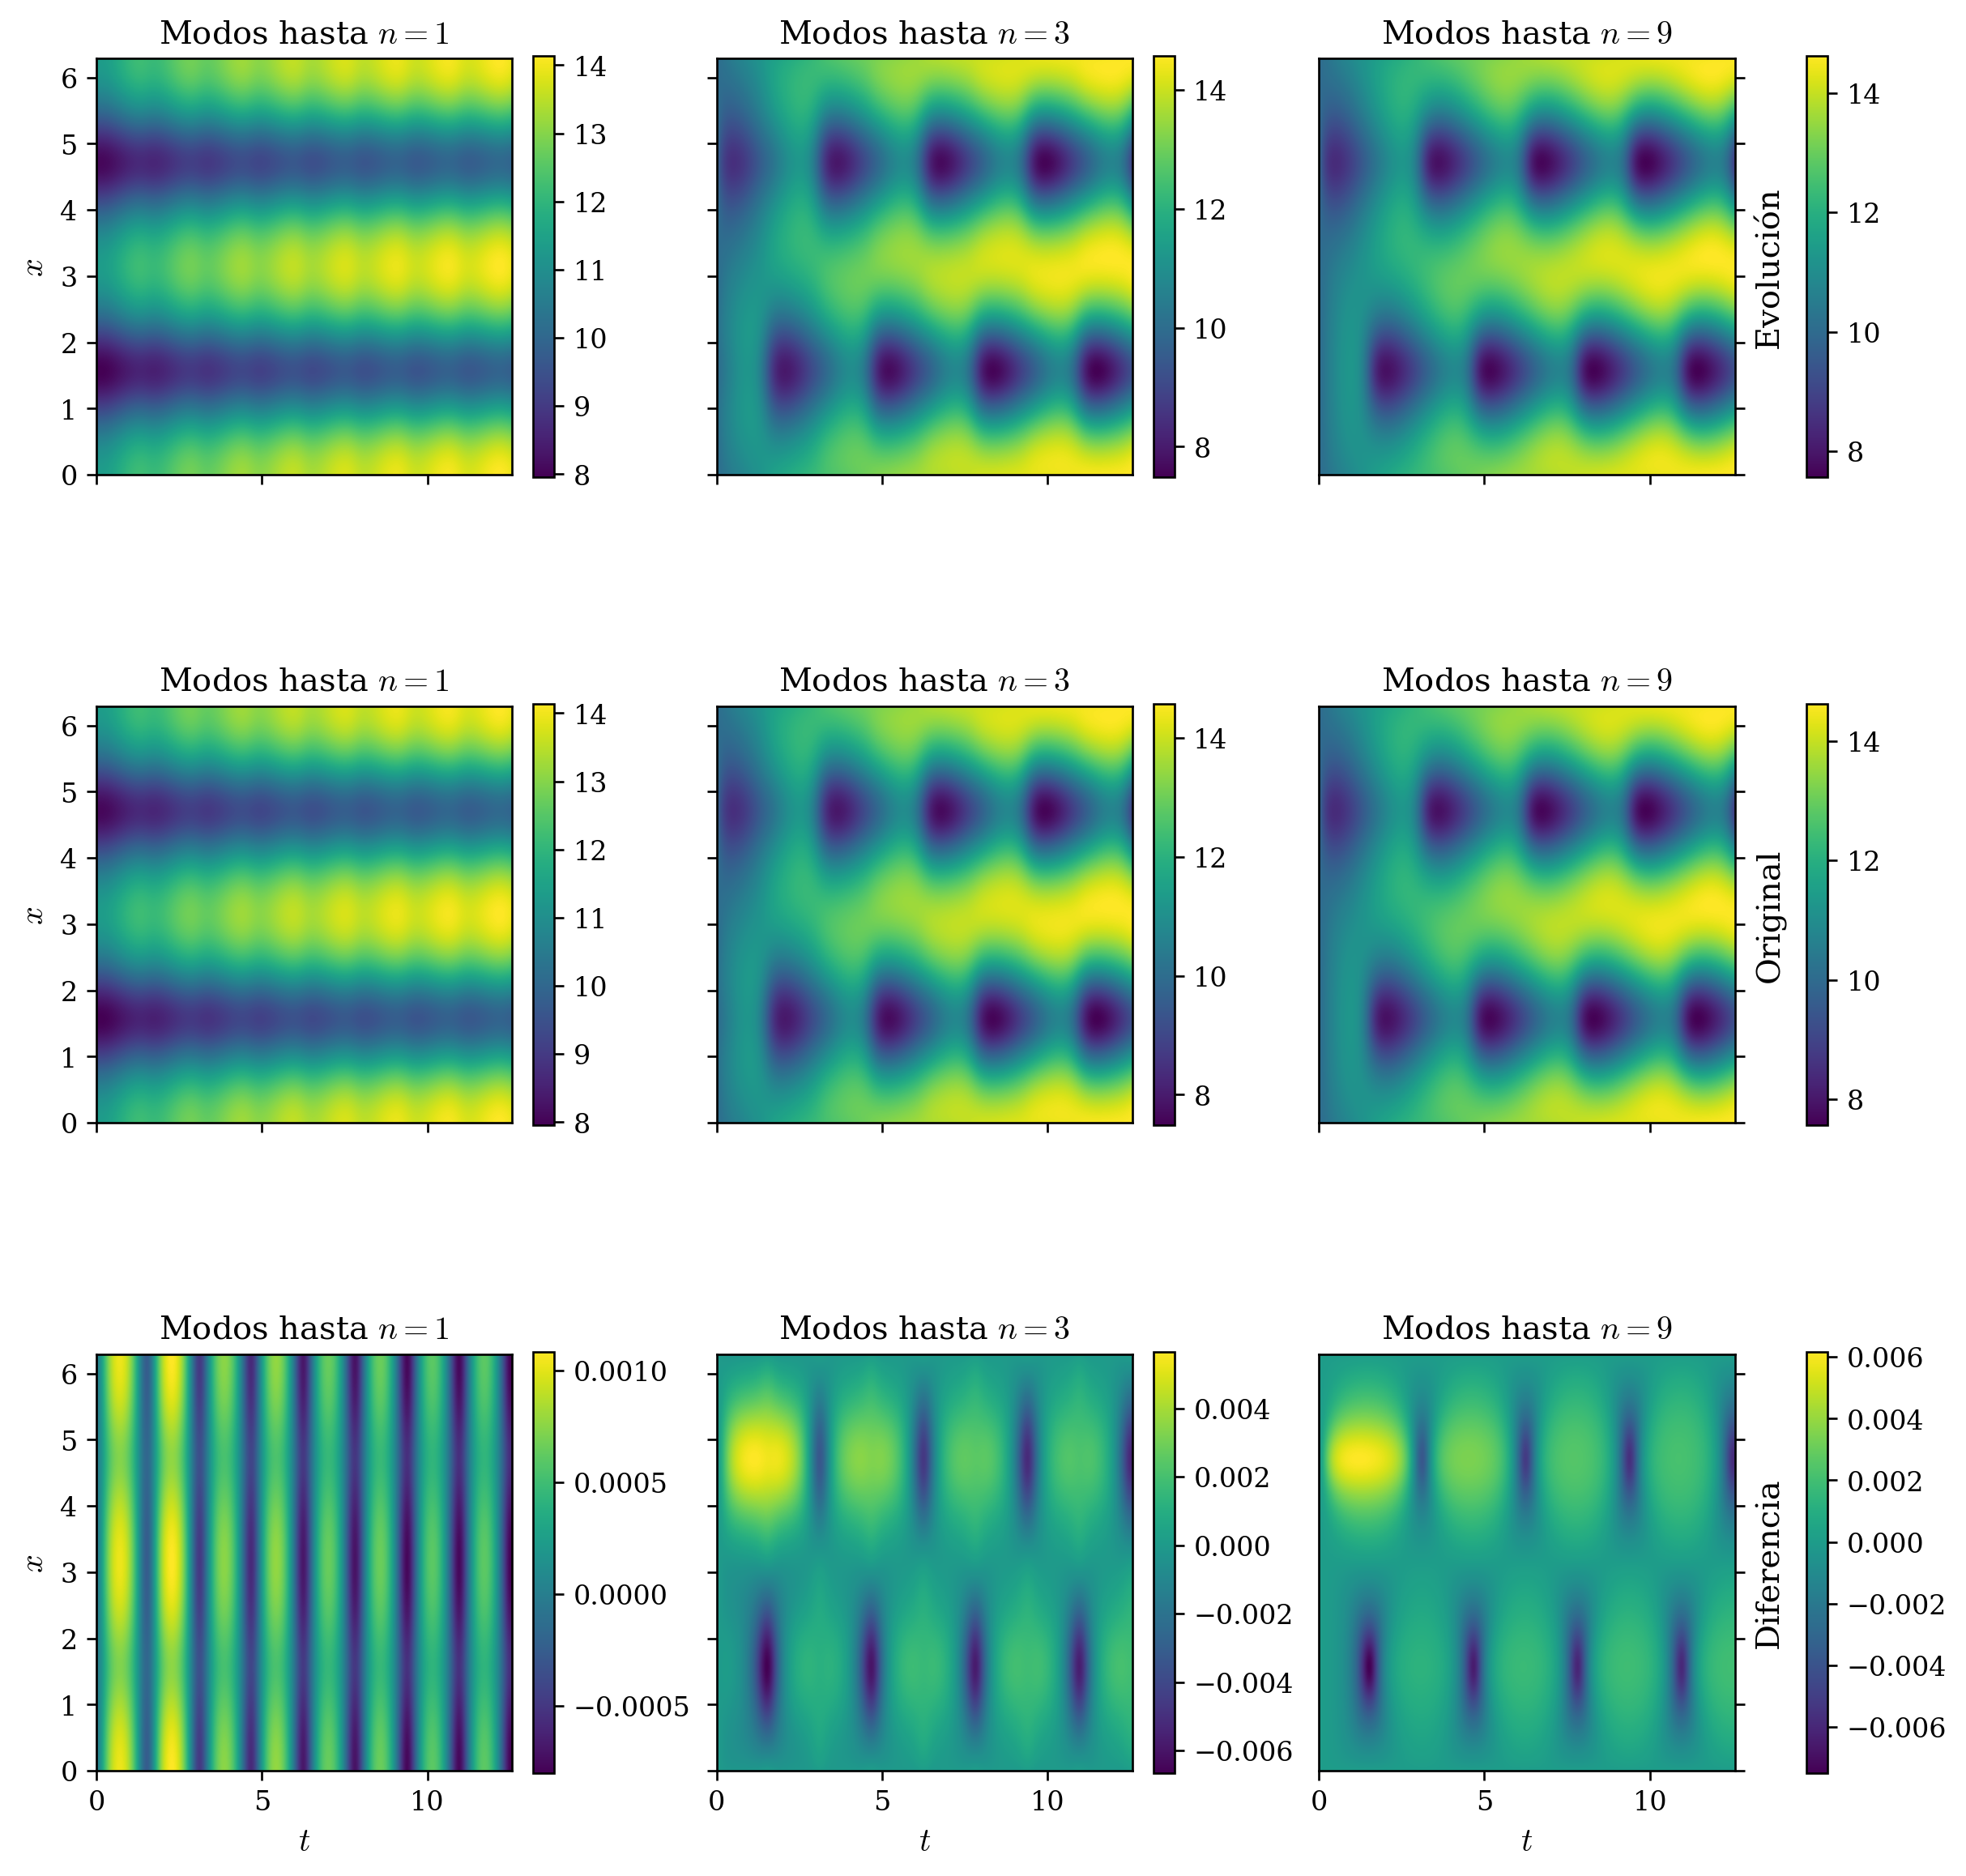

In [11]:
%matplotlib inline
fig, axs = plt.subplots(
    3, 3,
    sharex=True, sharey=True,
    constrained_layout=True, squeeze=False,
    figsize=(10, 10),
)
modo_cmap = dict()
for row_id, (ax_row, a_mat, tag) in enumerate(zip(axs, [a_evol, a], ["Evolución", "Original"])):
    ax_row[-1].set_ylabel(tag)
    ax_row[-1].yaxis.tick_right()
    ax_row[-1].yaxis.set_label_position("right")
    for i, ax in zip([0, 2, 8], ax_row):
        ax.set_title(f"Modos hasta $n={i+1}$")
        modo = phi[:, :i+1] @ a_mat[:, :i+1].T
        modo_cmap[f"{i} {tag}"] = plt.cm.ScalarMappable(
            norm=plt.Normalize(modo.flatten().min(), modo.flatten().max()),
            cmap="viridis",
        )
        ax.pcolormesh(
            t_grid, x_grid,
            modo_cmap[f"{i} {tag}"].to_rgba(modo.T),
            shading="auto",
        )
        ax.set_aspect(t_vals.max() / x_vals.max())
        plt.colorbar(modo_cmap[f"{i} {tag}"], ax=ax, shrink=2/3)
ax_row = axs[-1]
tag = "Diferencia"
ax_row[-1].set_ylabel(tag)
ax_row[-1].yaxis.tick_right()
ax_row[-1].yaxis.set_label_position("right")
for i, ax in zip([0, 2, 8], ax_row):
    ax.set_title(f"Modos hasta $n={i+1}$")
    diferencia = phi[:, :i+1] @ a_evol[:, :i+1].T - phi[:, :i+1] @ a[:, :i+1].T
    modo_cmap[f"{i} {tag}"] = plt.cm.ScalarMappable(
            norm=plt.Normalize(diferencia.flatten().min(), diferencia.flatten().max()),
            cmap="viridis",
        )
    ax.pcolormesh(
        t_grid, x_grid,
        modo_cmap[f"{i} {tag}"].to_rgba(diferencia.T),
        shading="auto",
    )
    ax.set_aspect(t_vals.max() / x_vals.max())
    plt.colorbar(modo_cmap[f"{i} {tag}"], ax=ax, shrink=2/3)
for ax in axs[-1]:
    ax.set_xlabel("$t$")
for ax in axs[:, 0]:
    ax.set_ylabel("$x$")
plt.show()

Observando la similaridad entre las soluciones evolucionadas y las hayadas originalmente se puede concluir que la integración de la ecuación:
$$\dot{\vec{a}}(t) = \alpha \vec{A} - \left(\alpha \mathbb{T}(t) - \nu \mathbb{B}\right)\, \vec{a}(t)$$
mediante un RK4 es suficientemente parecida a la integración de la ecuación original a primer orden.

Dicho eso, a medida que se agregan modos de menor peso ("mayor $n$") el error aumenta. Para estudiar esto más en detalle graficamos los $\vec{a}$ originales y los $\vec{a}^\prime$ evolucionados a partir de Galerkin para distintos $n$.

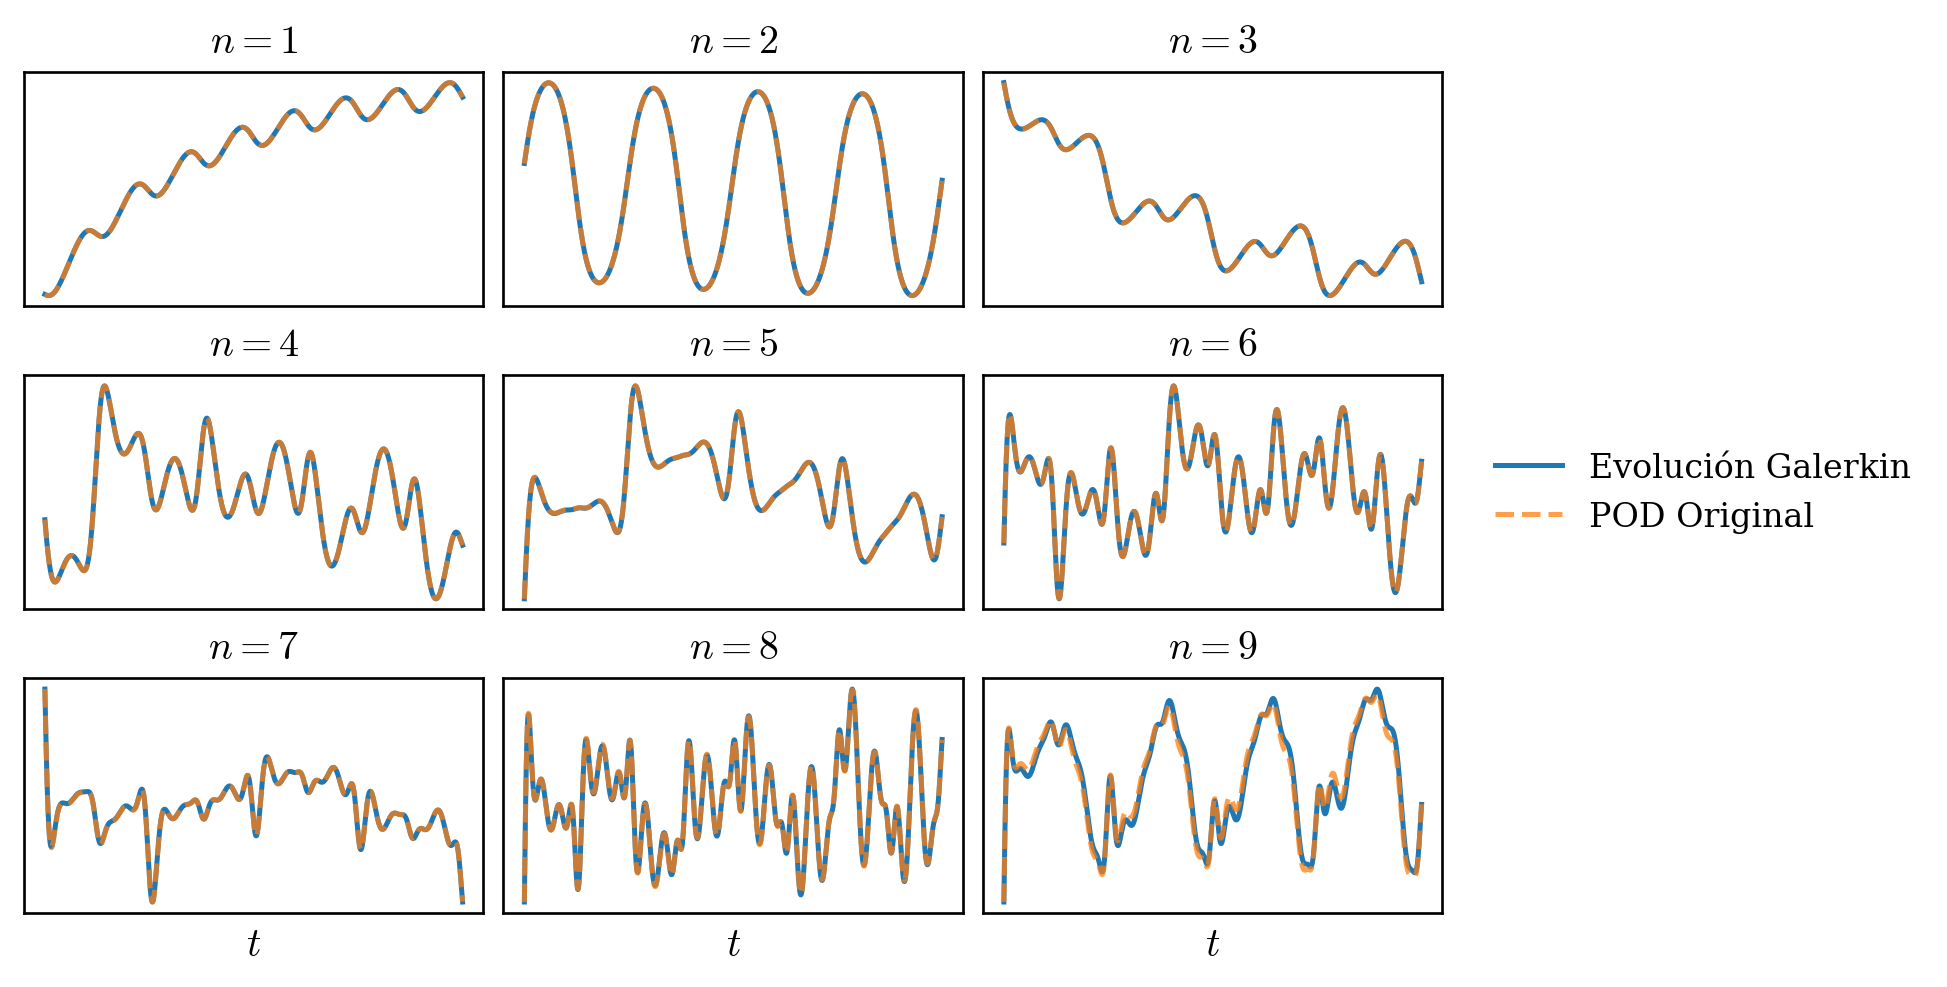

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(8, 4), constrained_layout=True, squeeze=False, sharex=True)
for i, ax in enumerate(axs.flatten()):
    ax.set_title(f"$n={i+1}$")
    # ax.plot(t_vals, (a_evol[:, i] - a[:, i])/np.abs(a[:, i]), lw=1.5,)
    ax.plot(t_vals, a_evol[:, i], lw=1.5, label="Evolución Galerkin")
    ax.plot(t_vals, a[:, i], "--", lw=1.5, alpha=0.75, label="POD Original")
    # ax.grid()
    ax.set_yticks([])
    ax.set_xticks([])
for ax in axs[-1, :]:
    ax.set_xlabel("$t$")
axs[1, -1].legend(bbox_to_anchor=(1.05, 0.5), loc='center left', frameon=False)
plt.show()


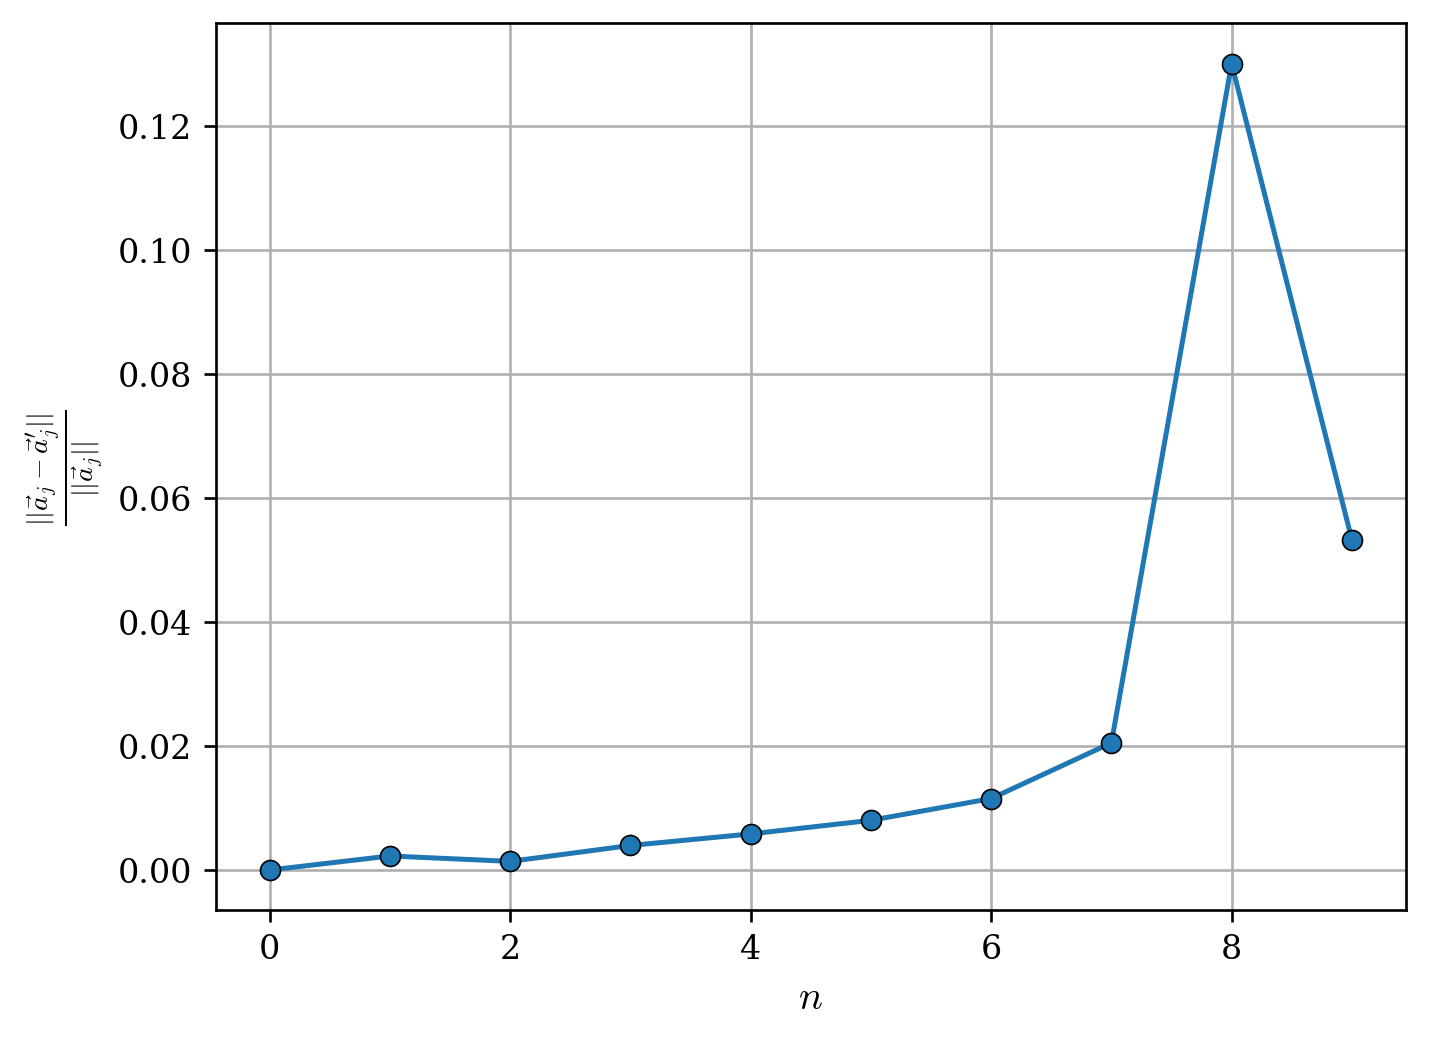

In [13]:
fig, ax = plt.subplots(1, 1)
ax.plot(
    np.arange(a_evol.shape[1]),
    (np.linalg.norm(a_evol - a[:, :a_evol.shape[1]], axis=0)
     / np.linalg.norm(a[:, :a_evol.shape[1]], axis=0)),
    "o-", mec="k", mew=0.5, lw=1.5,
)
plt.grid()
ax.set_xlabel("$n$")
ax.set_ylabel(r"$\frac{||\vec{a}_j - \vec{a}^\prime_j||}{||\vec{a}_j||}$")
plt.show()


Acá observamos que para mayor $n$ el error aumenta. Esto podría deberse al hecho de que los modos más altos son aquellos que tienen menos peso en la solución original y están mayormente asociados al ruido, teniendo su evolución menos relevancia física (recordemos, estos contienen menos del $0,00001\%$ de la energía del sistema).

## f)

In [5]:
alpha_vals = [0.01, 0.5, 3, 10, 100]
for alpha in alpha_vals:
    try:
        w1=2
        i_truncado = 3
        a_evol = np.load(f"evol_mats/a_n{i_truncado}_alpha{alpha}_w1{w1}_evol.npy")
    except FileNotFoundError:
        a_0 = a[0][:i_truncado+1]
        phi_modos = phi[:, :i_truncado+1]
        a_evol = runge_kutta_4(
            f_evol,
            a_0,
            dt,
            steps=(t_vals.size - 1),
            phi_matrix=phi_modos,
            alpha=alpha,
            nu=nu,
            c0=15,
            w1=w1,
            w2=1,
        )
        np.save(f"evol_mats/a_n{i_truncado}_alpha{alpha}_w1{w1}_evol.npy", a_evol)

In [6]:
# Evolución con Pseudo-Espectral

for alpha in tqdm(alpha_vals, desc="Variando α"):
    try:
        n_pseudo = np.load(f"evol_mats/N_alpha{alpha}_w1{w1}.npy")
    except FileNotFoundError:
        n_pseudo = np.empty([nx, nt])  # Array con la velocidad
        n_pseudo[:, 0] = np.full_like(x_vals, 10, dtype=float)  # CI: 10 individuos en todos los puntos

        # Evolucionamos en el tiempo
        for i, t_i in enumerate(t_vals[:-1]):
            n_pseudo[:, i+1] = evol(
                n_pseudo[:, i],
                k_vals,
                lambda t: c_func(x_vals, t, c0=15, w1=2, w2=1),
                alpha,
                nu,
                dt,
                t_i,
            )
        np.save(f"evol_mats/N_alpha{alpha}_w1{w1}.npy", n_pseudo)

Variando α:   0%|          | 0/5 [00:00<?, ?it/s]

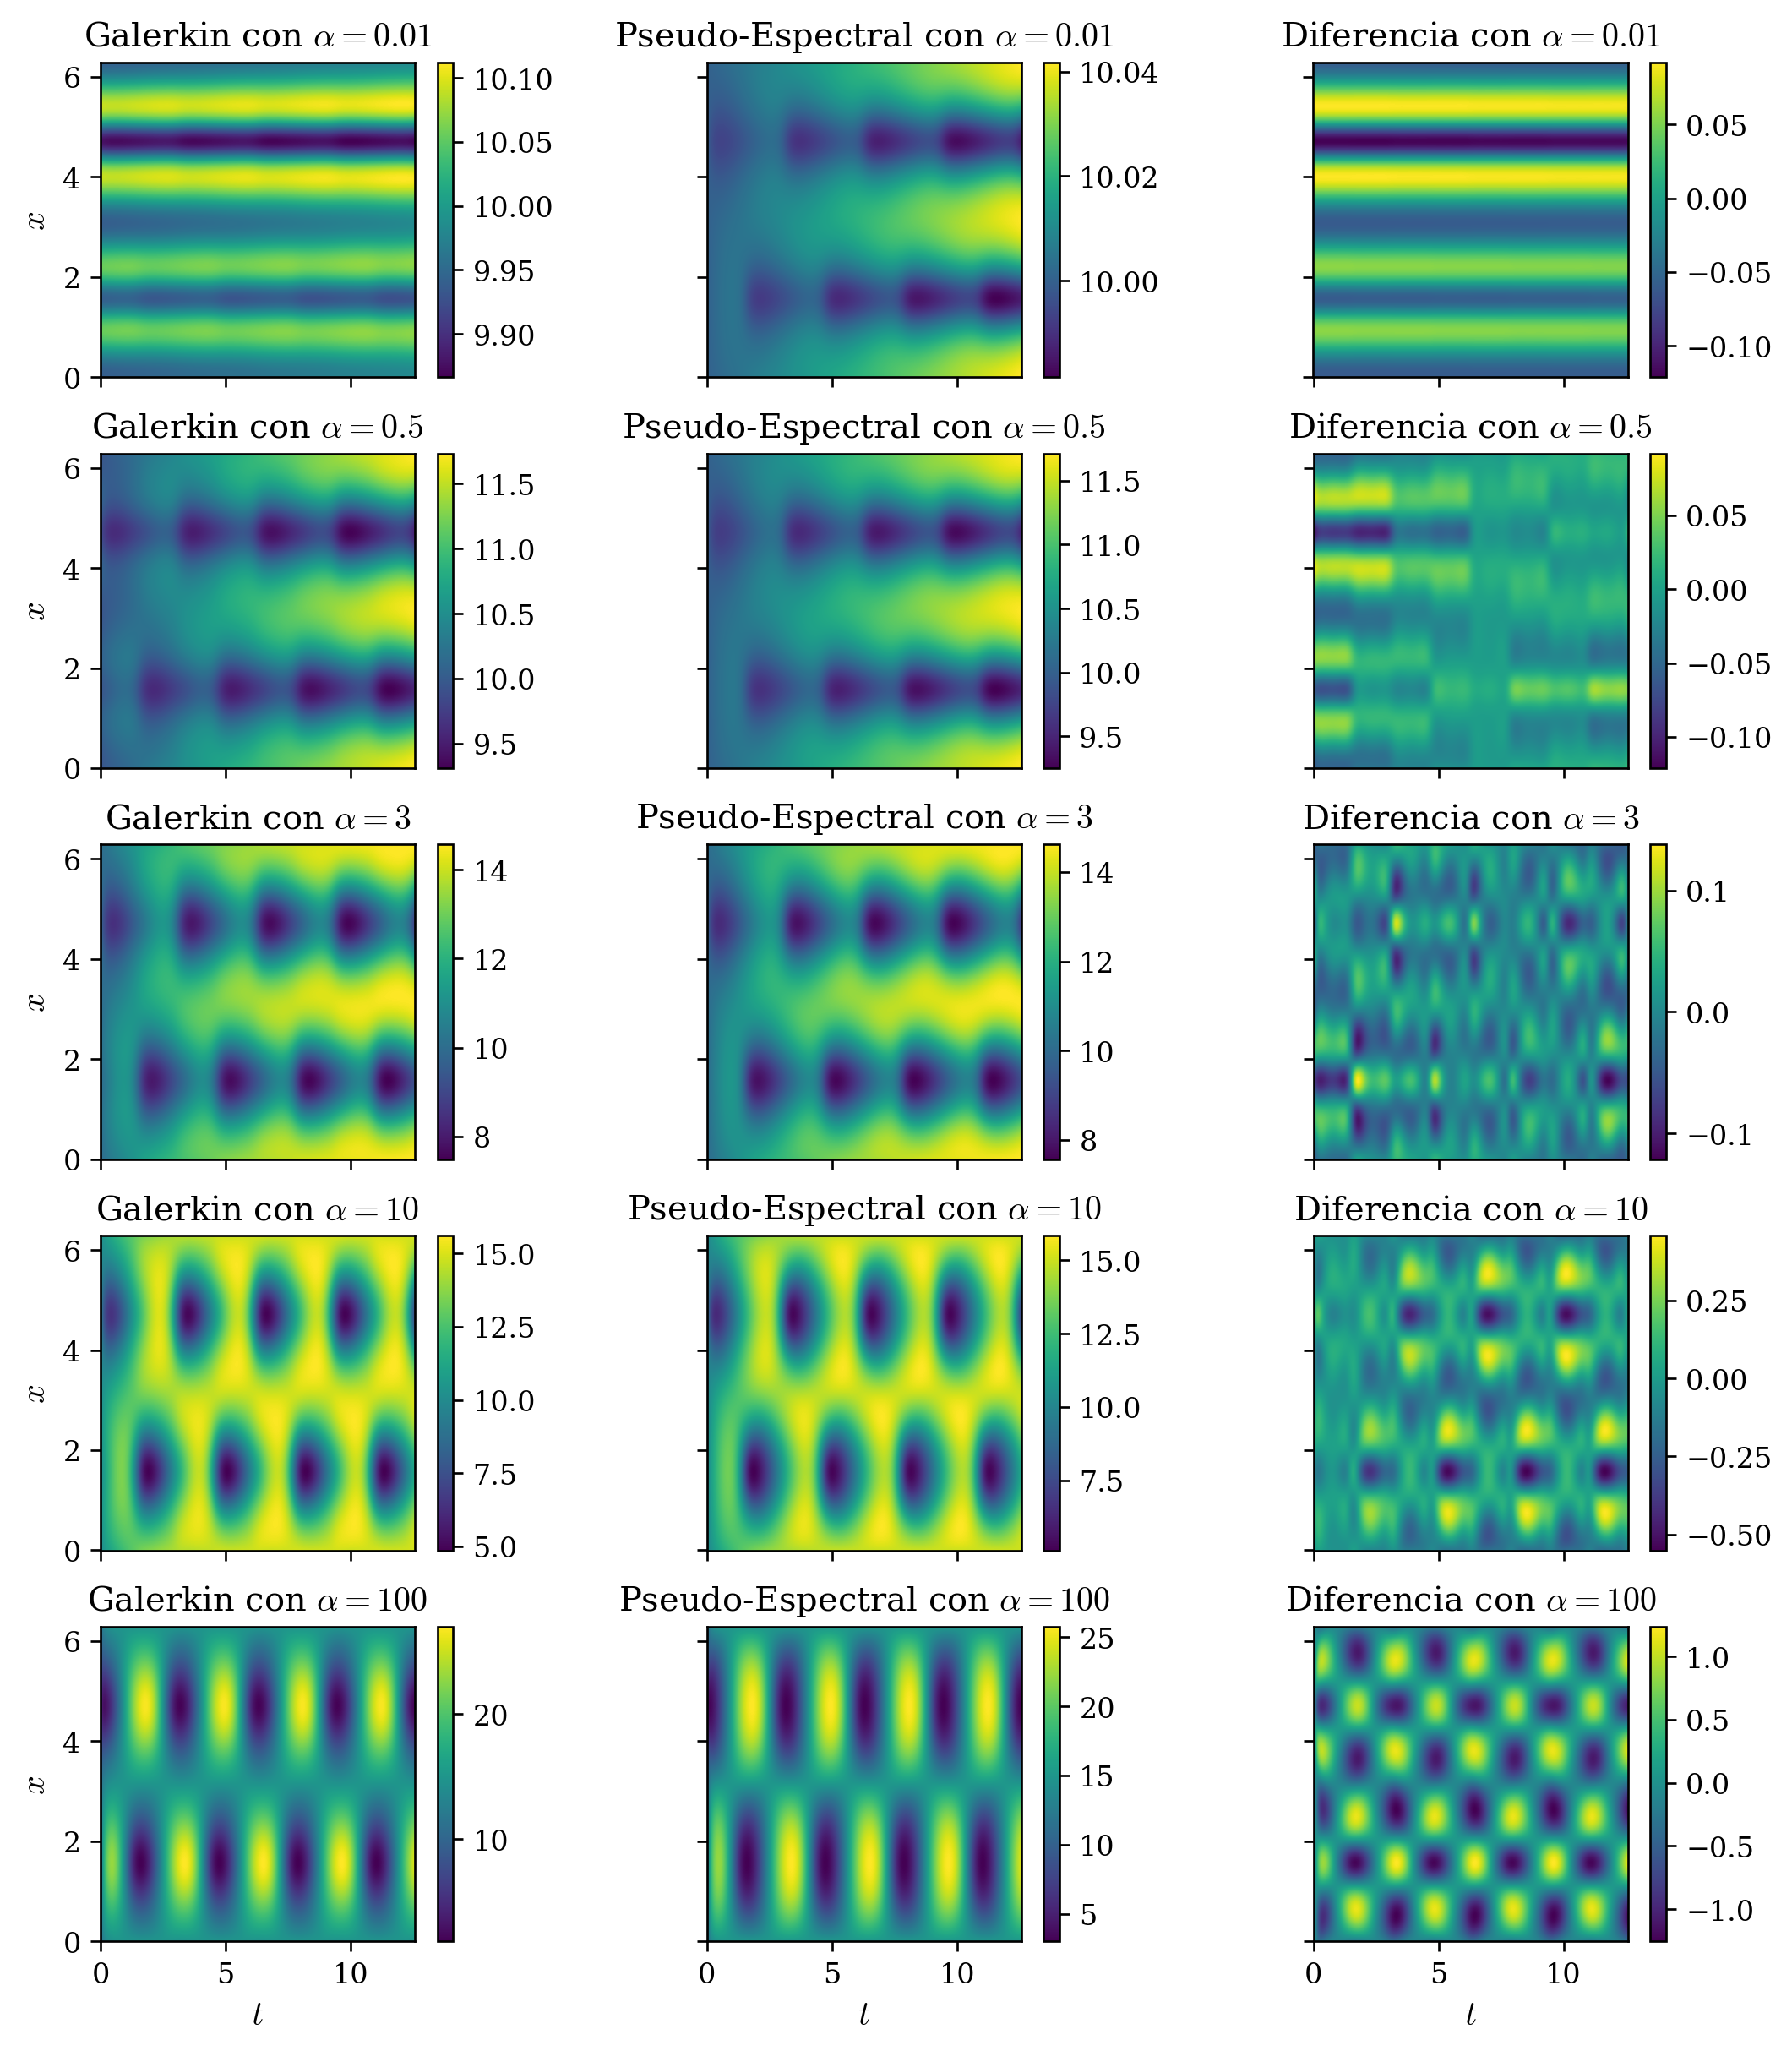

In [12]:
fig, axs = plt.subplots(
    len(alpha_vals), 3, figsize=(9, 10),
    squeeze=False, sharex=True, sharey=True, constrained_layout=True)
n_trunc = 3
for alpha, ax_row in zip(alpha_vals, axs):
    a_evol = np.load(f"evol_mats/a_n{i_truncado}_alpha{alpha}_w1{w1}_evol.npy")
    n_galerkin = phi[:, :n_trunc] @ a_evol[:, :n_trunc].T
    n_pseudo = np.load(f"evol_mats/N_alpha{alpha}_w1{w1}.npy")
    for ax, tag, n in zip(
        ax_row,
        ["Galerkin", "Pseudo-Espectral", "Diferencia"],
        [n_galerkin, n_pseudo, n_galerkin - n_pseudo],
    ):
        ax.set_title(rf"{tag} con $\alpha={alpha}$")
        cmap = ax.pcolormesh(t_grid, x_grid, n.T, shading="auto", cmap="viridis")
        ax.set_aspect(t_vals.max() / x_vals.max())
        plt.colorbar(cmap, ax=ax, orientation="vertical")
for ax in axs[:, 0]:
    ax.set_ylabel("$x$")
for ax in axs[-1, :]:
    ax.set_xlabel("$t$")
plt.show()

In [15]:
plt.close("all")

Podemos observar que para valores de $\alpha$ desde 0.5 ambos métodos se comportan de manera similar. Sin embargo, para $\alpha$ 0.01 el método de Galerkin se aleja significativamente (y cualitativamente) de la solución hayada mediante el método pseudoespectral.

Entendemos que lo primero se debe a que los modos encontrados mediante POD para $\alpha=3$ representan bien la evolución del sistema espacialmente cuando la población puede responder suficientemente rápido al desplazamiento de los recursos (agrupandose rápidamente alrededor de los "picos" generados por $C(x, t)$). Mientras tanto, observamos que con $\alpha =0.01$ el sistema evoluciona muy lentamente y los modos de mayor peso en la solución de $\alpha = 3$ difieren significativamente de los modos predominantes para este caso. En este último escenario la respuesta de la población no es lo suficientemente rápida y se observa una dinámica distinta.

Adicionalmente, la tercera columna del gráfico de arriba muestra la diferencia entre la integración por Galerkin de los primeros 3 modos y la integración de todo el sistema con el método pseudo-espectral. Sin embaego, como no se truncó la solución del método pseudoespectral en 3 modos, las diferencias que se observan para $\alpha \geq 0.5$ parecieran deberse a los modos faltantes y no a diferencias en la integración. (aplicar POD a cada solución de Pseudoespectral para $\alpha \geq 0.5$ y comparar con Galerkin se hacía muy pesado computacionalmente y no se llegó a hacer).

## g)

En las siguientes celdas repetimos la integración para $\omega_1 = 1$ a partir de los 3 modos más presentes en el caso de $\omega_1 = 2$:

In [19]:
alpha = 3
w1 = 1
i_truncado = 3
try:
    a_evol = np.load(f"evol_mats/a_n{i_truncado}_alpha{alpha}_w1{w1}_evol.npy")
except FileNotFoundError:
    a_0 = a[0][:i_truncado+1]
    phi_truncado = phi[:, :i_truncado+1]
    a_evol = runge_kutta_4(
        f_evol,
        a_0,
        dt,
        steps=(t_vals.size - 1),
        phi_matrix=phi_truncado,
        alpha=alpha,
        nu=nu,
        c0=15,
        w1=w1,
        w2=1,
    )
    np.save(f"evol_mats/a_n{i_truncado}_alpha{alpha}_w1{w1}_evol.npy", a_evol)

Y la integración por pseudo-espectral para $\omega_1 = 1$:

In [20]:
try:
    n_pseudo = np.load(f"evol_mats/N_alpha{alpha}_w1{w1}.npy")
except FileNotFoundError:
    n_pseudo = np.empty([nx, nt])  # Array con la velocidad
    n_pseudo[:, 0] = np.full_like(x_vals, 10, dtype=float)  # CI: 10 individuos en todos los puntos

    # Evolucionamos en el tiempo
    for i, t_i in enumerate(t_vals[:-1]):
        n_pseudo[:, i+1] = evol(
            n_pseudo[:, i],
            k_vals,
            lambda t: c_func(x_vals, t, c0=15, w1=w1, w2=1),
            alpha,
            nu,
            dt,
            t_i,
        )
    np.save(f"evol_mats/N_alpha{alpha}_w1{w1}.npy", n_pseudo)

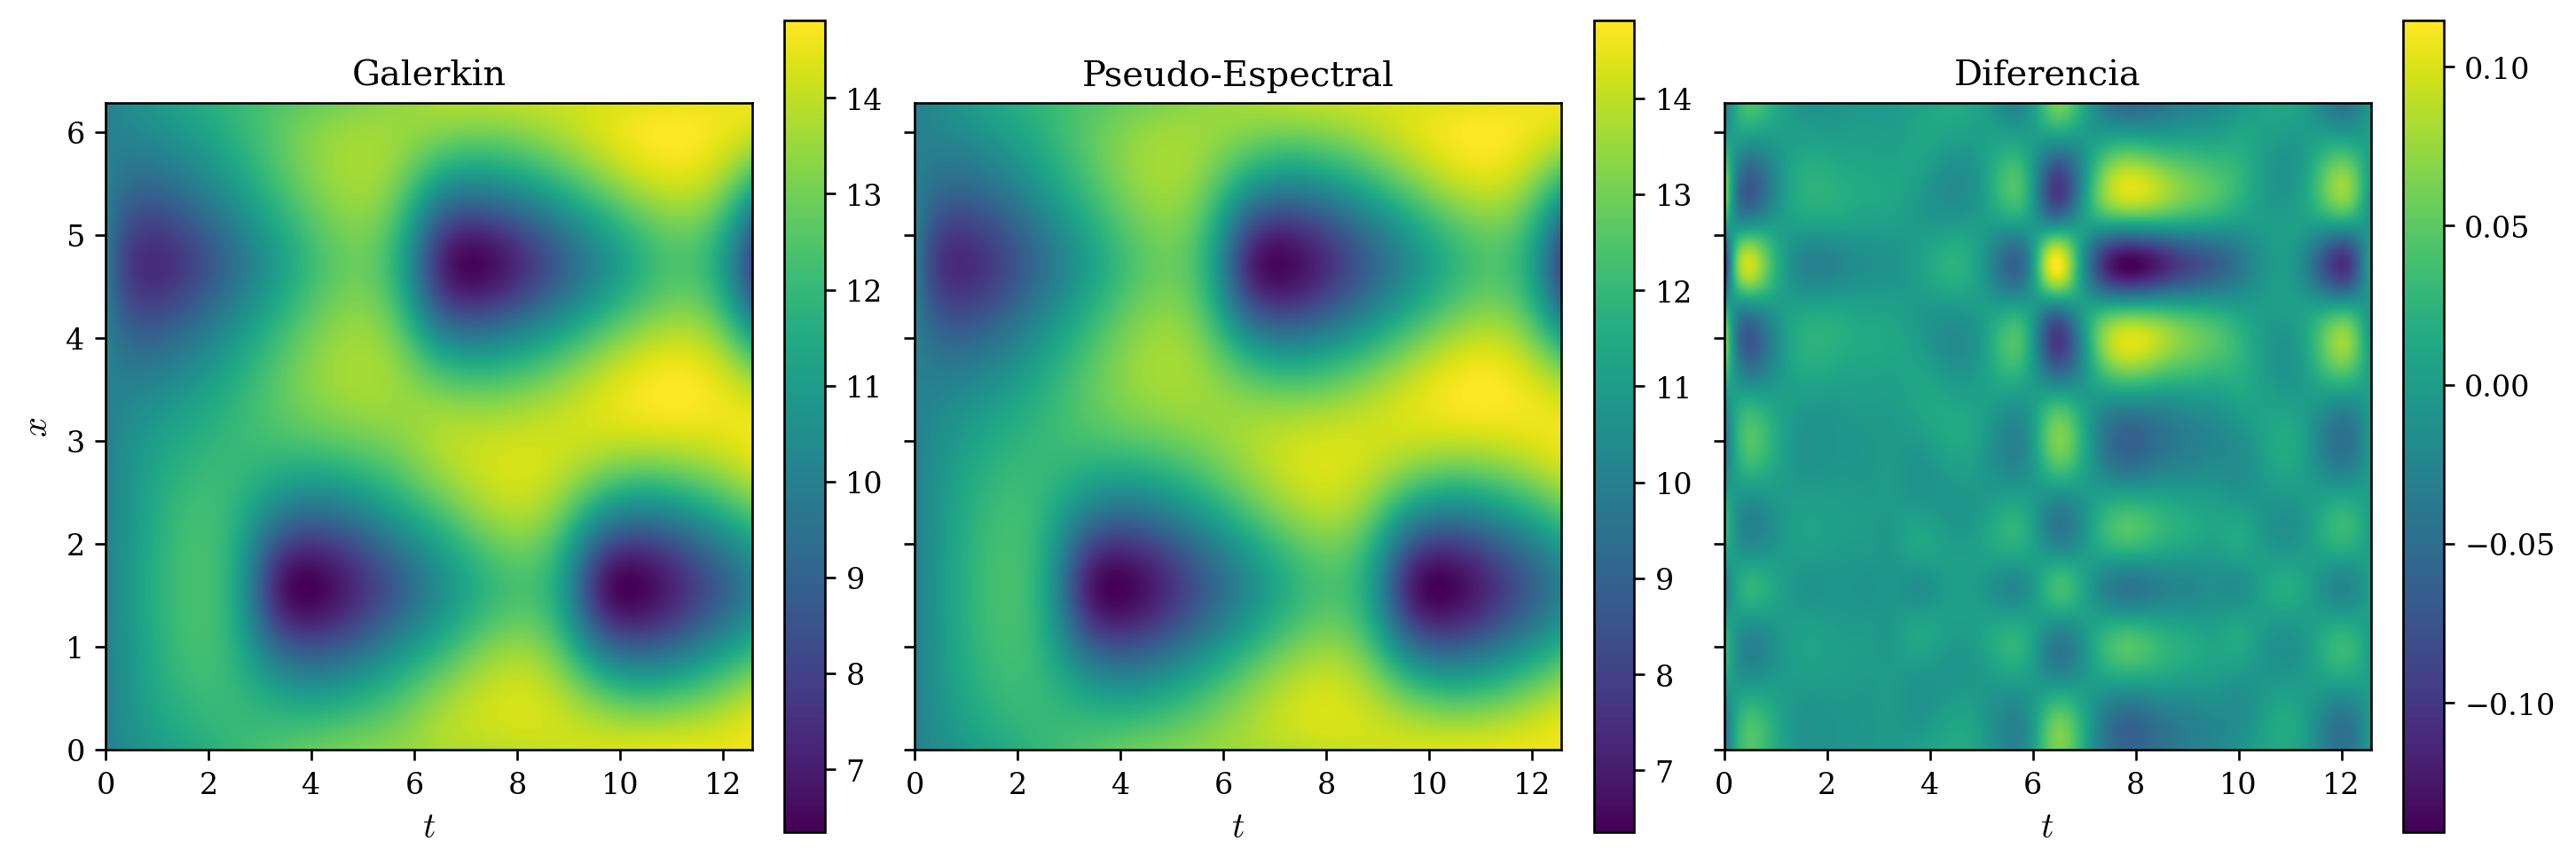

In [21]:
fig, axs = plt.subplots(
    1, 3, figsize=(12, 4),
    squeeze=True, sharex=True, sharey=True, constrained_layout=True)
n_trunc = 3
# a_evol = np.load(f"evol_mats/a_n{i_truncado}_alpha{alpha}_w1{w1}_evol.npy")
n_galerkin = phi[:, :n_trunc + 1] @ a_evol[:, :n_trunc + 1].T
# n_pseudo = np.load(f"evol_mats/N_alpha{alpha}_w1{w1}.npy")
for ax, tag, n in zip(
    axs,
    ["Galerkin", "Pseudo-Espectral", "Diferencia"],
    [n_galerkin, n_pseudo, n_galerkin - n_pseudo],
):
    ax.set_title(rf"{tag}")
    cmap = ax.pcolormesh(t_grid, x_grid, n.T, shading="auto", cmap="viridis")
    ax.set_aspect(t_vals.max() / x_vals.max())
    plt.colorbar(cmap, ax=ax, orientation="vertical")
axs[0].set_ylabel("$x$")
for ax in axs:
    ax.set_xlabel("$t$")
plt.show()

Una vez más observamos que el modos empiricos calculados para $\alpha=3$ y $\omega_1=2$ generalizan bien al integrar la evolución del sistema para $\omega_1=1$. En este caso aún más que en el caso anterior, esto resulta razonable dado que el parámetro $\omega_1$ afecta exclusivamente la dependencia temporal de $C(x, t)$, de manera que es razonable que la solución de tipo variable separadas que se obtiene de Galerkin (y POD) para la dependencia de $x$ es la misma para ambos casos.

## h)